http://criminalidad.inei.gob.pe

# Imports / load data

In [1]:
import os
os.chdir('..')
%load_ext autoreload
%autoreload 2

In [146]:
import json
import numpy as np, pandas as pd, seaborn as sns, unidecode, math, rfpimp, altair as alt
import matplotlib.pyplot as plt
from pathlib import Path
from perustats import inei_series, plots
alt.renderers.enable('notebook')
%matplotlib inline

In [3]:
df = pd.read_csv('data/processed/criminality/vaw-endes.csv', low_memory=False)
df.head(2)

location                                           variable  year  value
0  Nacional  MUJERES DE 15 A 49 AÑOS DE EDAD QUE BUSCARON A...  2009  0.236
1  Amazonas  MUJERES DE 15 A 49 AÑOS DE EDAD QUE BUSCARON A...  2009  0.199

# Plots

In [10]:
col2abb = {
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE SUFRIERON VIOLENCIA FÍSICA, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO': 'Physical violence',
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE SUFRIERON VIOLENCIA PSICOLÓGICA Y/O VERBAL, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO': 'Psychological violence',
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE SUFRIERON VIOLENCIA PSICOLÓGICA, FÍSCA Y/O SEXUAL, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO': 'Violence',
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE SUFRIERON VIOLENCIA SEXUAL, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO': 'Sexual violence',
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE TUVIERON CONSECUENCIAS DE LA VIOLENCIA FÍSICA, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO / Herida o lesión, hueso o dientes rotos, quemaduras': 'Serious injuries',
'MUJERES DE 15 A 49 AÑOS DE EDAD ALGUNA VEZ UNIDAS QUE TUVIERON CONSECUENCIAS DE LA VIOLENCIA FÍSICA, EJERCIDA ALGUNA VEZ POR EL ESPOSO O COMPAÑERO / Moretones y dolores': 'Injuries',
'MUJERES DE 15 A 49 AÑOS DE EDAD QUE BUSCARON AYUDA  EN PERSONAS CERCANAS CUANDO FUERON MALTRATADAS FÍSICAMENTE': 'People support',
'MUJERES DE 15 A 49 AÑOS DE EDAD QUE BUSCARON AYUDA EN ALGUNA INSTITUCIÓN CUANDO FUERON MALTRATADAS FÍSICAMENTE': 'Institutional support',
'MUJERES DE 15 A 49 AÑOS DE EDAD QUE SUFRIERON VIOLENCIA FÍSICA, EJERCIDA ALGUNA VEZ POR OTRA PERSONA, APARTE DE SU ACTUAL/ÚLTIMO ESPOSO OCOMPAÑERO': 'violencia fisica no pareja',
}
abb2col = {v:k for k,v in col2abb.items()}
dff = df[(df.location != 'Nacional') & (df.year != '2017(I sem)')].reset_index(drop=True)
dff.variable = dff.variable.apply(lambda x: col2abb[x])
dff = dff[~dff.location.isin(['Lima', 'Lima Provincias', 'Callao'])]
dff.loc[dff.location == 'Áncash', 'location'] = 'Ancash'
dff.loc[dff.location == 'Lima/Callao', 'location'] = 'Lima'
dff.head(2)

location               variable  year  value
0  Amazonas  Institutional support  2009  0.199
1    Ancash  Institutional support  2009  0.252

## Save for D3

In [164]:
d3 = dff[dff.variable != 'violencia fisica no pareja'].copy()
d3.location = d3.location.apply(lambda x: unidecode.unidecode(x).upper())
d3.head()

location               variable  year  value
0  AMAZONAS  Institutional support  2009  0.199
1    ANCASH  Institutional support  2009  0.252
2  APURIMAC  Institutional support  2009  0.336
3  AREQUIPA  Institutional support  2009  0.337
4  AYACUCHO  Institutional support  2009  0.247

In [165]:
d3_dict = {}
i=0
for y in d3.year.unique():
    d3_dict[y] = {}
    for l in d3.location.unique():
        t = d3.query(f'location == {l!r} and year == {y!r}')[['variable', 'value']].round(2).values
        d3_dict[y][l] = {e[0]:e[1] for e in t}

In [168]:
PATHD3 = Path('data/processed/vaw')
PATHD3.mkdir(parents=True, exist_ok=True)

In [177]:
json.dump(d3_dict, (PATHD3/'data.json').open('w'))

## Timelines

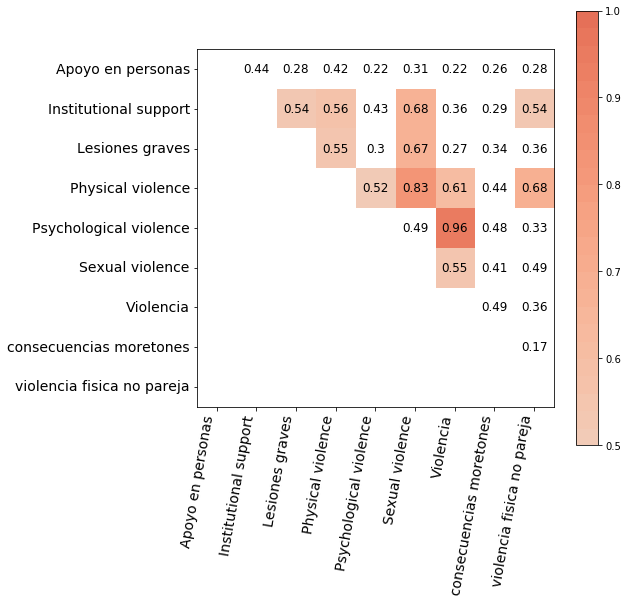

In [5]:
rfpimp.plot_corr_heatmap(dff[(dff.year == '2016')].
                             set_index(['location', 'variable'])['value'].unstack(),
                         threshold=0.5, figsize=(8,8))

Institutional support:


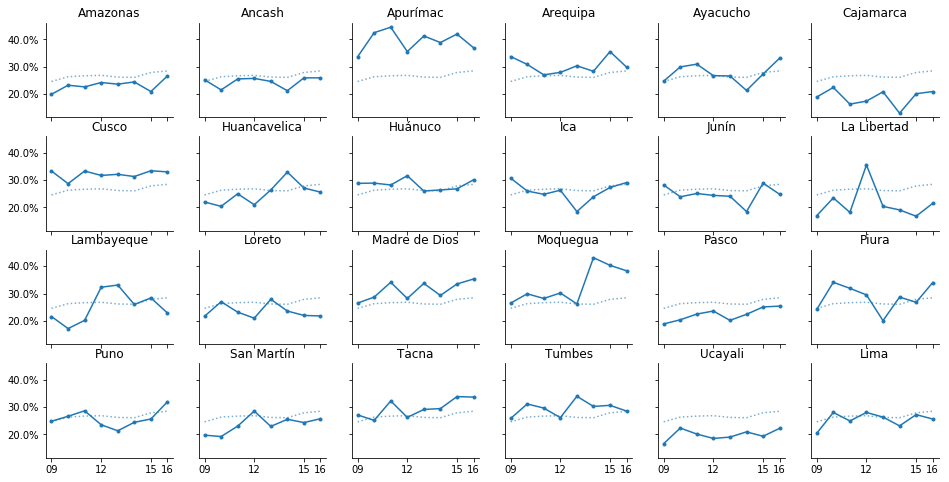

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Sexual violence:


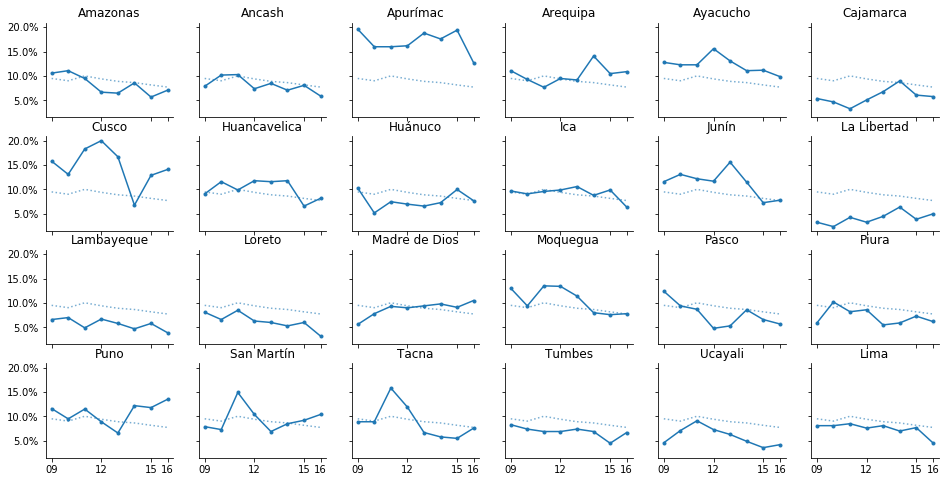

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Apoyo en personas:


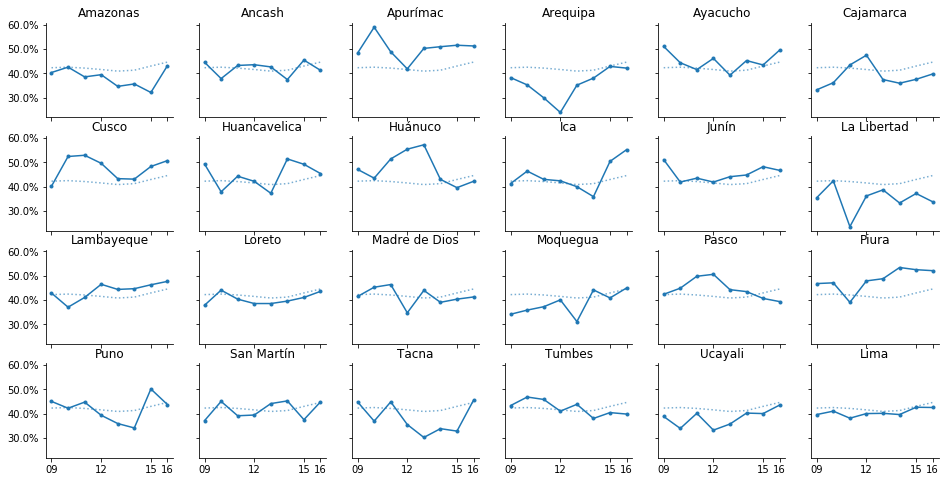

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Violencia:


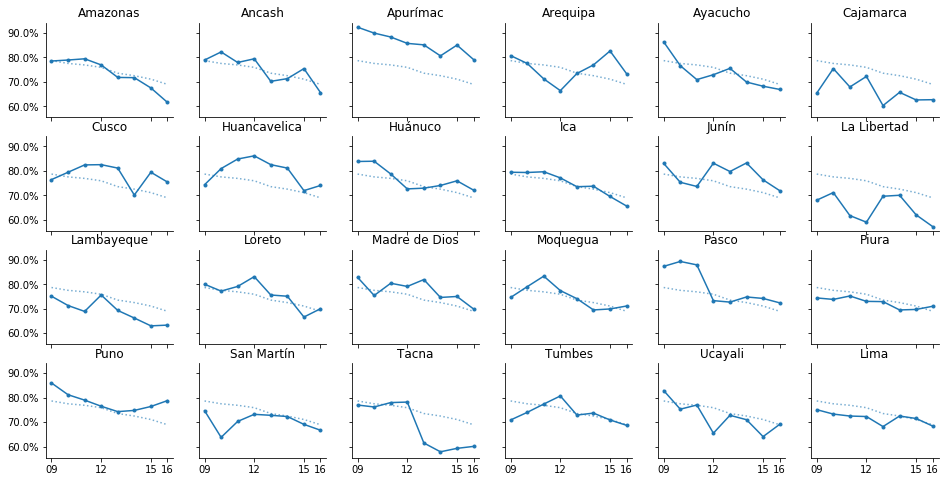

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
consecuencias moretones:


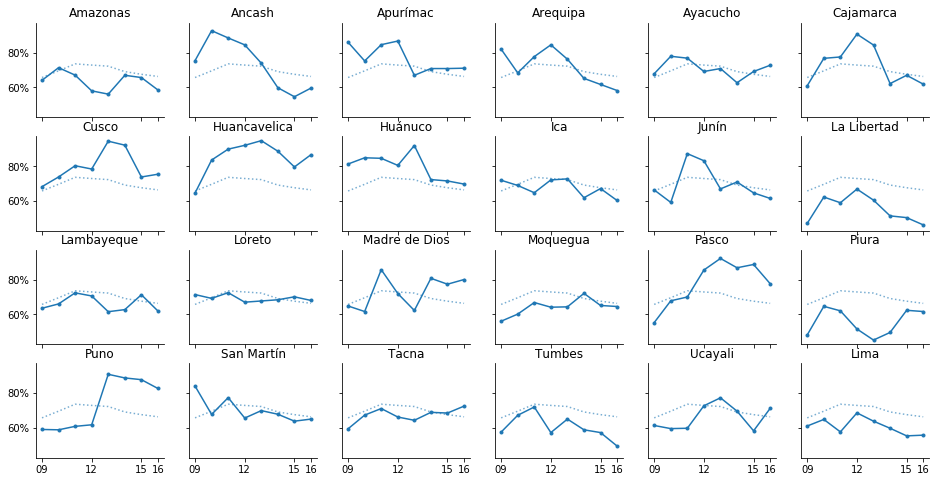

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Lesiones graves:


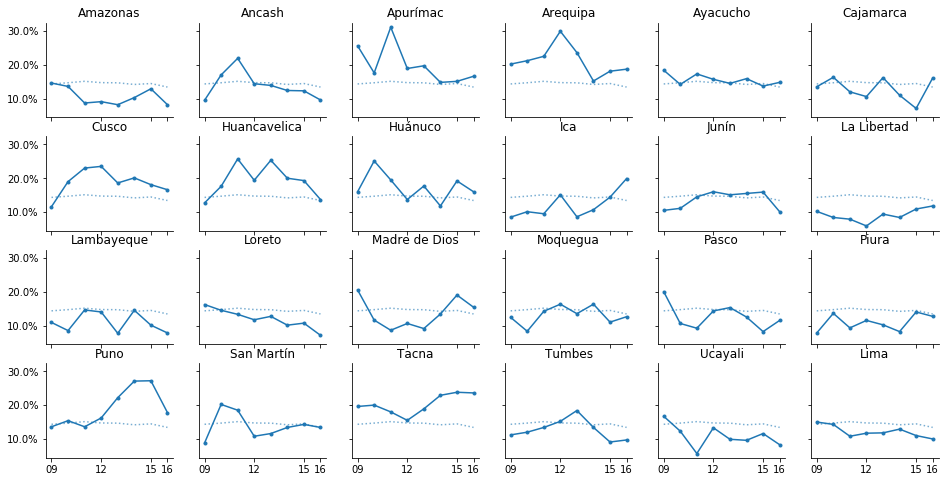

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Psychological violence:


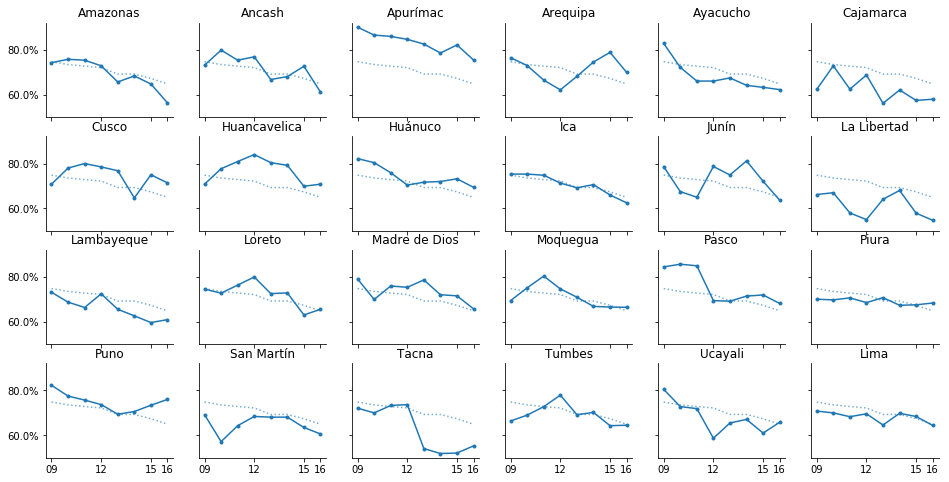

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
Physical violence:


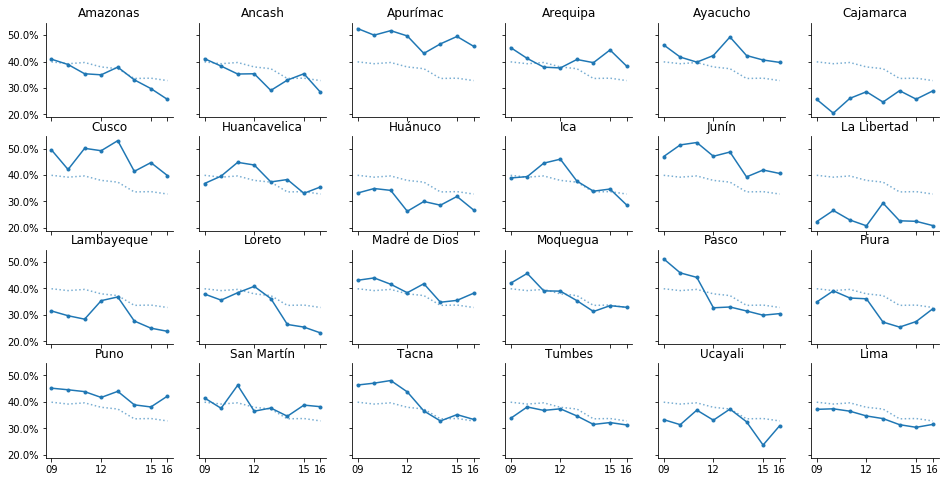

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.
violencia fisica no pareja:


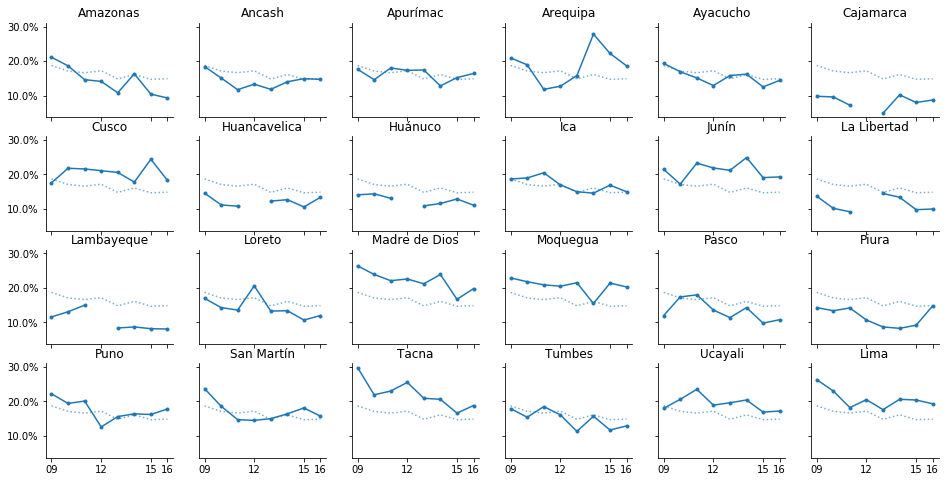

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.


In [6]:
for v in dff.variable.unique():
    plots.timeline_grid(dff, 'value', 'year', 'location', 'variable', v, title=v,
                        cols=6, fs=(16,8), percentage=True)
    break


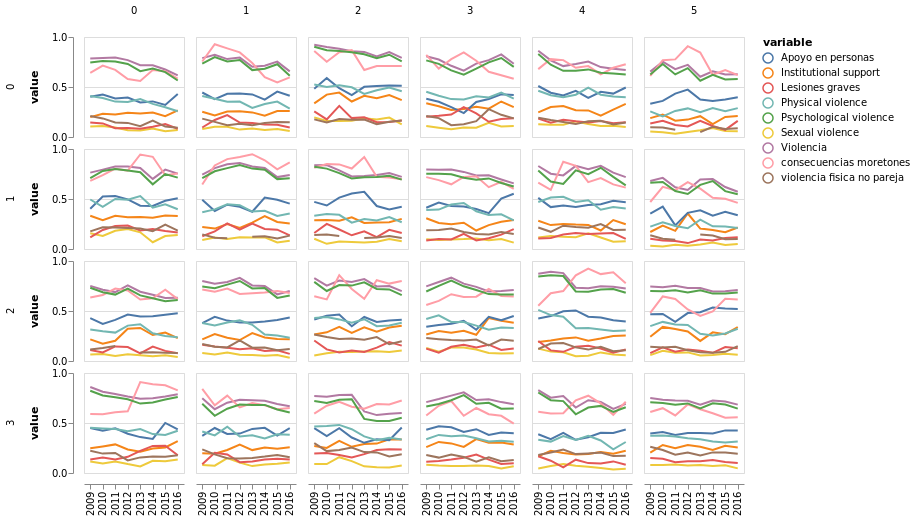

In [7]:
idx = dff.location.unique()
n_col = 6
n_row = math.ceil(len(idx)/n_col)
gridx_dict = {i:e for i,e in zip(idx, np.repeat(range(n_row), n_col)[:len(idx)])}
gridy_dict = {i:e for i,e in zip(idx, (list(range(n_col)) * n_row)[:len(idx)])}


dfff = dff.copy()
dfff['gridx'] = dfff.location.apply(lambda x: gridx_dict[x])
dfff['gridy'] = dfff.location.apply(lambda x: gridy_dict[x])

slider = alt.binding_select(options=dff.variable.unique().tolist())
select = alt.selection_single(name='variable', fields=['variable'], bind=slider)

alt.Chart(dfff).mark_line().encode(
    alt.X('year', title=None), alt.Y('value'),
    alt.Color('variable'),
    alt.Row('gridx:N', title=None),
    alt.Column('gridy:N', title=None)
).transform_filter(
    select
).properties(
    selection=select,
    width=100, height=100
)


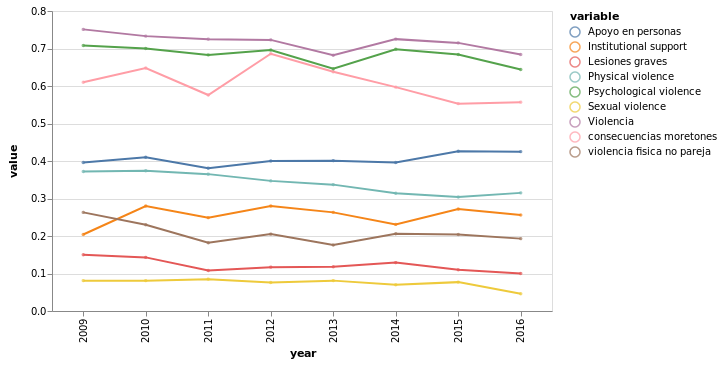

In [9]:
chart = alt.Chart(dff.query('location == "Lima"')).mark_line().encode(
    x='year:O', y='value:Q', color='variable', size=alt.value(2)
).properties(
    width=500
)
chart.interactive() + chart.mark_point()

In [ ]:
'Institutional support',
'Sexual violence',
'Apoyo en personas',
'Violencia',
'consecuencias moretones',
'Lesiones graves',
'Psychological violence',
'Physical violence',
'violencia fisica no pareja'

In [ ]:
fig = plots.timeline_grid(dff, 'value', 'year', 'location', 'variable',
                    [
#                         'Institutional support',
'Psychological violence',
'Sexual violence',
# 'Apoyo en personas',
# 'Violencia',
# 'consecuencias moretones',
# 'Lesiones graves',
'Physical violence',
# 'violencia fisica no pareja'
                    ],
                    cols=6, percentage=True, legend=True, fs=(16,10),
                    legend_bbox=(-6, 5.7), legend_loc='upper left');

In [ ]:
fig = plots.timeline_grid(dff, 'value', 'year', 'location', 'variable',
                    [
                        'Apoyo en institucion',
#                         'Violencia sexual',
#                         'Apoyo en personas',
#                         'Violencia',
#                         'consecuencias moretones',
                        'Lesiones graves',
#                         'Violencia psicologica',
                        'Violencia fisica',
#                         'violencia fisica no pareja'
                    ],
                    cols=6, percentage=True, legend=True, fs=(16,9),
                    legend_bbox=(-6, 5.5), legend_loc='upper left');

## Interactive plots

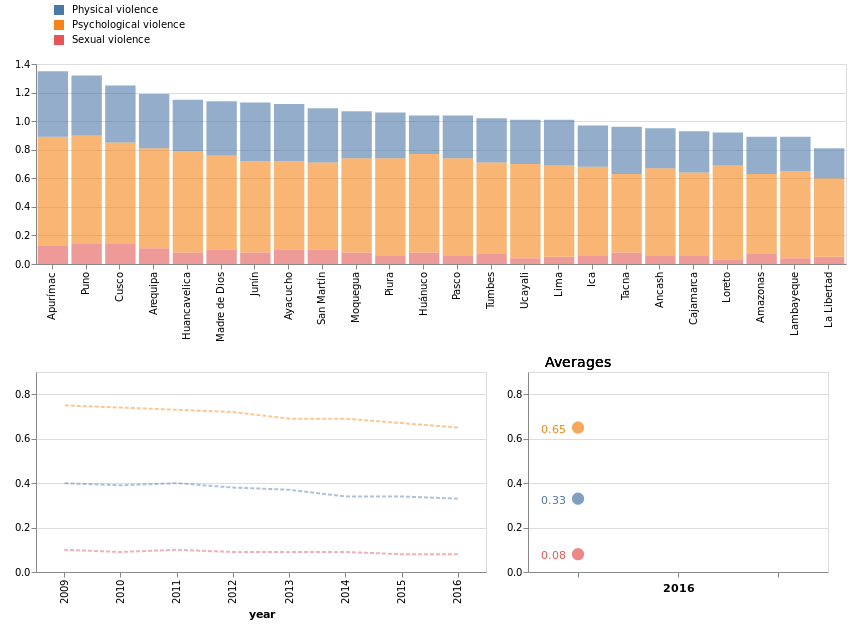

In [68]:
v = [
'Psychological violence',
'Sexual violence',
'Physical violence',
]
chart = plots.tl_summary(dff[dff.variable.isin(v)], values='value', time='year', bars='location',
                         col='variable', text='', slope_avg='Averages')
chart.save('reports/charts/vaw-violence-vars.html')
chart

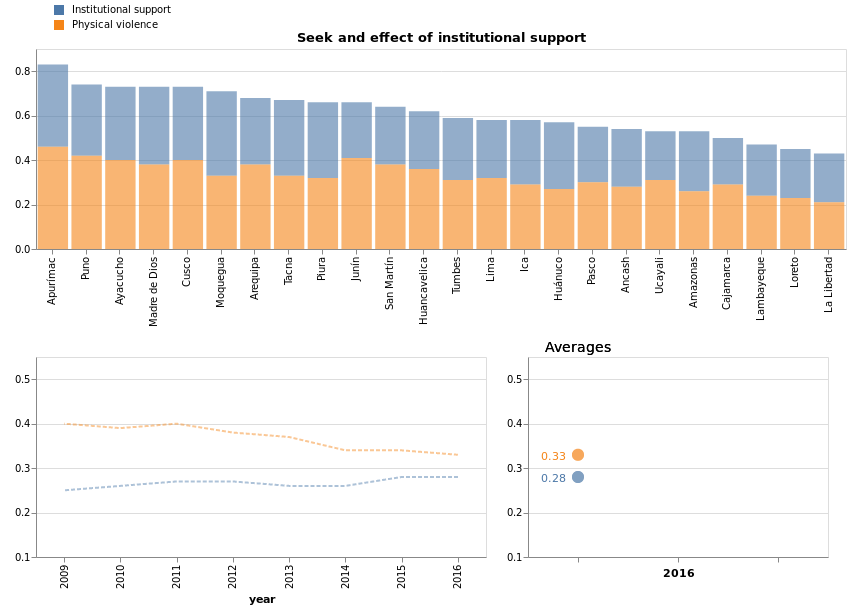

In [66]:
v = [
'Institutional support',
'Physical violence',
]
chart = plots.tl_summary(dff[dff.variable.isin(v)], values='value', time='year', bars='location',
                         col='variable', text='', slope_avg='Averages',
                         title='Seek and effect of institutional support')
chart.save('reports/charts/vaw-institutional-support.html')
chart

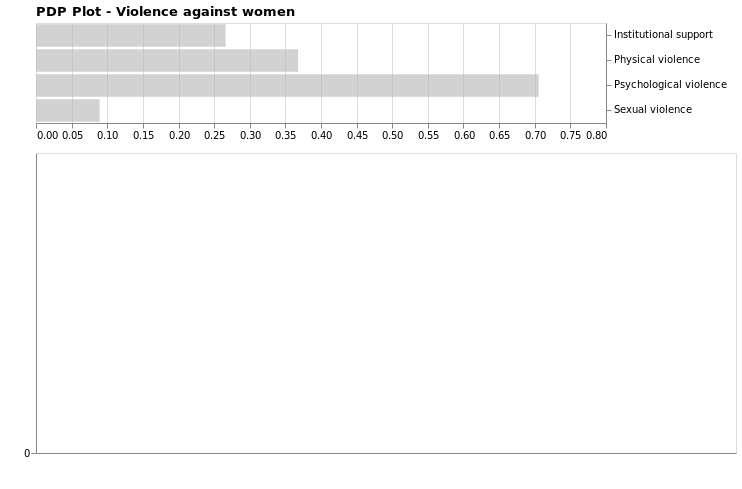

In [12]:
v = [
'Psychological violence',
'Sexual violence',
'Physical violence',
'Institutional support',
]
plots.pdp_explore(dff[dff.variable.isin(v)],
                  rows='location', columns='year', values='value', cluster_centers=3,
                  variables='variable', title='PDP Plot - Violence against women', bars_h=100, height=300)

In [134]:
dff.variable.unique()

array(['ayuda institucion', 'violencia sexual', 'ayuda personas',
       'violencia', 'consecuencias moretones', 'consecuencias graves',
       'violencia psicologica', 'violencia fisica',
       'violencia fisica no pareja'], dtype=object)

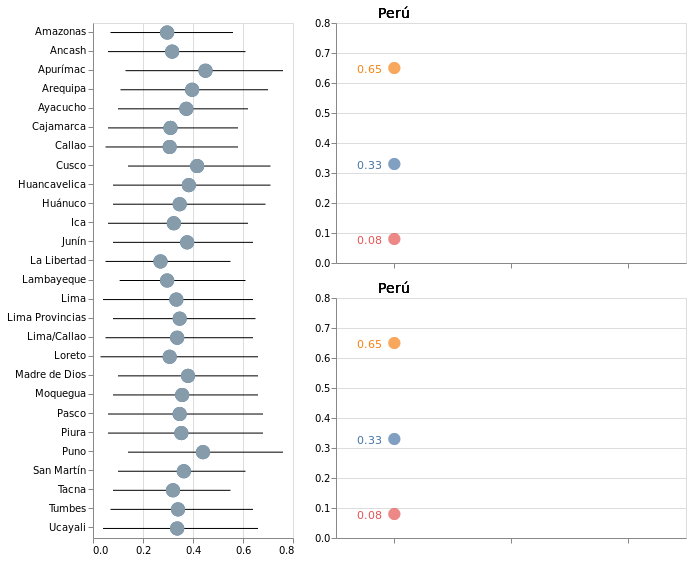

In [135]:
plots.slope_comparison(dff[dff.variable.isin(['violencia psicologica', 'violencia fisica', 'violencia sexual'])].query('year == "2016"'),
                       values='value', bars='location',
                       col='variable', text='', slope_avg='Perú', slope_y_title='')

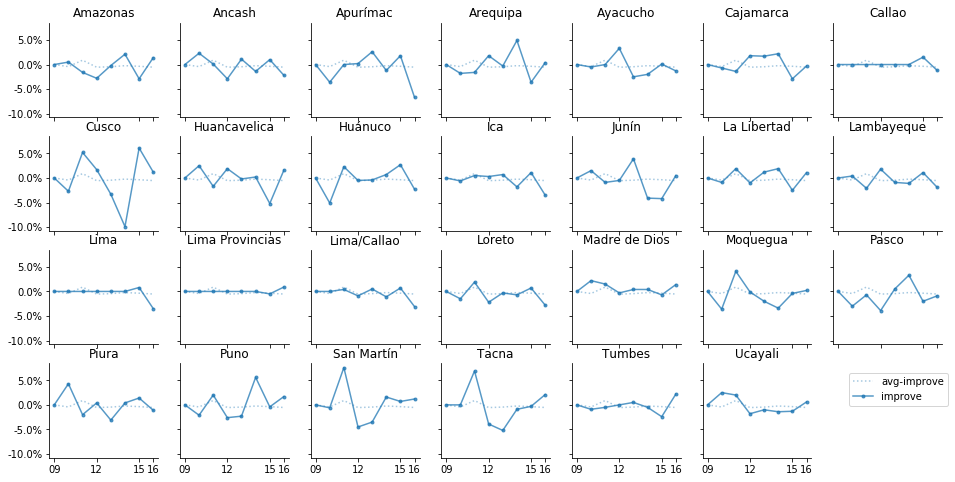

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.


In [125]:
t =  dff.query('variable == "violencia sexual"').copy()
t = t.set_index(['year', 'location'])['value'].unstack()
t = (t - t.shift()).fillna(0)
t = t.stack().reset_index().rename({0:'value'}, axis=1).assign(variable='improve')
plots.timeline_grid(t, 'value', 'year', 'location', 'variable',
                    cols=7, percentage=True, legend=True, fs=(16,8),
                    legend_bbox=(1.8, 0.9), legend_loc='upper center');

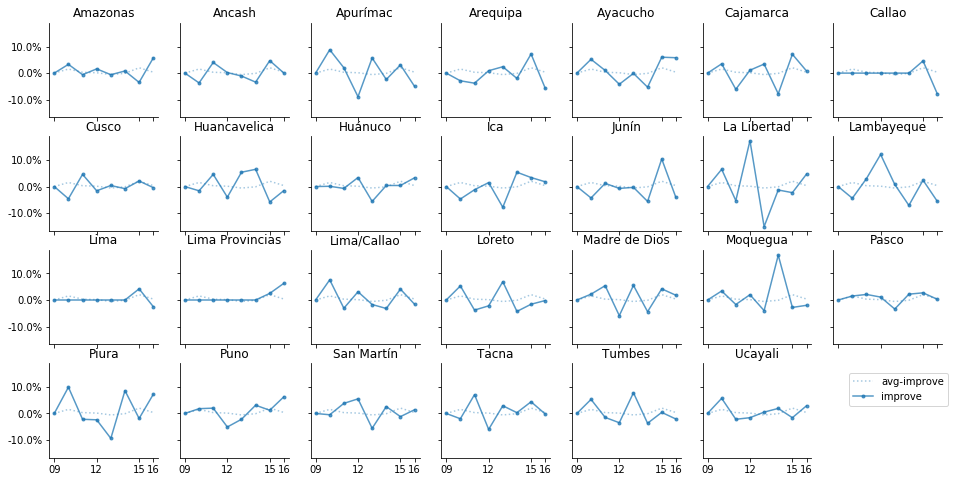

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.


In [124]:
t =  dff.query('variable == "ayuda institucion"').copy()
t = t.set_index(['year', 'location'])['value'].unstack()
t = (t - t.shift()).fillna(0)
t = t.stack().reset_index().rename({0:'value'}, axis=1).assign(variable='improve')
plots.timeline_grid(t, 'value', 'year', 'location', 'variable',
                    cols=7, percentage=True, legend=True, fs=(16,8),
                    legend_bbox=(1.8, 0.9), legend_loc='upper center');

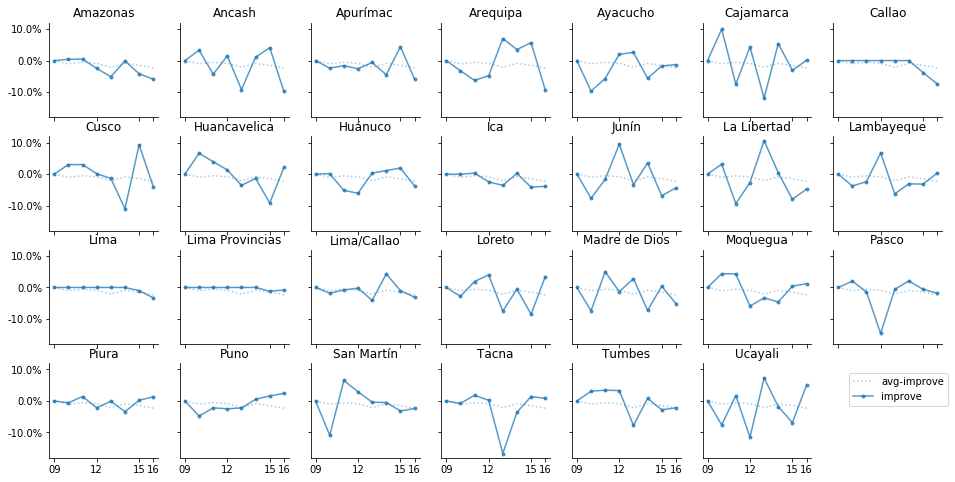

Years: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016.


In [122]:
t =  dff.query('variable == "violencia"').copy()
t = t.set_index(['year', 'location'])['value'].unstack()
t = (t - t.shift()).fillna(0)
t = t.stack().reset_index().rename({0:'value'}, axis=1).assign(variable='improve')
plots.timeline_grid(t, 'value', 'year', 'location', 'variable',
                    cols=7, percentage=True, legend=True, fs=(16,8),
                    legend_bbox=(1.8, 0.9), legend_loc='upper center');